In [1]:
import string
import re
import matplotlib.pyplot as plt

from numpy import array, asarray, zeros
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization

ImportError: cannot import name 'pad_sequences' from 'keras.preprocessing.sequence' (C:\Users\Yogesh\anaconda3\lib\site-packages\keras\preprocessing\sequence.py)

In [12]:
def preprocess_text(sen):
    
    # Remove punctuations
    sentence = sen.translate(str.maketrans('', '', string.punctuation))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lower the sentence
    sentence = sentence.lower()
    
    return sentence

In [13]:
df = pd.read_csv("data/merged_categories.csv")
del df["Unnamed: 0"]

df = df.sample(frac=1).reset_index()
del df["index"]

In [14]:
df.head()

,product_name,category,subcategory,detail_category,categories
0,Youth For 3 Hoodie - Camo White / YXL,Sweatshirts,Unclassified,Unclassified,"Unclassified,Sweatshirts"
1,St Patricks Day Doggies English Bulldog Chihua...,Unclassified,Unclassified,Unclassified,Unclassified
2,"Rare Lalique Crystal ""Coeur de Fleur"" Butterfl...",Unclassified,Unclassified,Unclassified,Unclassified
3,150WLEDHIGHBAY,Unclassified,Unclassified,Unclassified,Unclassified
4,General Finishes High Performance Water Based ...,Home,Unclassified,Unclassified,"Home,Unclassified"


In [15]:
# How many unique terms?
print(df["categories"].nunique())

4191


In [16]:
# There are some terms with occurrence as low as 1.
sum(df["categories"].value_counts() == 1)

1144

As observed above, out of 4,191 unique combinations of terms, 1,144 entries have the lowest occurrence. To prepare our train, validation, and test sets with stratification, we need to drop these terms.

In [17]:
# Filtering the rare terms.
data = df.groupby("categories").filter(lambda x: len(x) > 1)
data.shape

(781501, 5)

In [18]:
data = data.sample(frac=1).reset_index()
del data["index"]

In [2]:
data = pd.read_csv('output/Amazon_reviews_mid_f1.csv', dtype=str,)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'output/Amazon_reviews_mid_f1.csv'

In [20]:
data["product_name"][56]

'Wireless Gamepad Bluetooth LED Light for PS4 Controller(Red Camouflage)'

### Put category list in list due to make it compatible with MultiLabelBinarizer

In [21]:
X = data["product_name"].apply(preprocess_text)
y = data["categories"]

### Use stratified splits because of class imbalance

In [22]:
test_split = 0.3

# Initial train and test split.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_split, stratify = y.values, shuffle = True, random_state=4)

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(547050,)
(234451,)
(547050,)
(234451,)


In [24]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary = "true")
y_train = vectorizer.fit_transform(y_train).toarray()
y_test = vectorizer.transform(y_test).toarray()

We first get percentile estimates of the sequence lengths. The purpose will be clear in a moment.

In [25]:
data["product_name"].apply(lambda x: len(x.split(" "))).describe()

count    781501.000000
mean          8.699881
std           4.898925
min           1.000000
25%           6.000000
50%           8.000000
75%          11.000000
max          84.000000
Name: product_name, dtype: float64

Notice that 50% of the abstracts have a length of 8. So, any number close to that value is a good enough approximate for the maximum sequence length. However, I will chose max_len according to max value

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ", vocab_size)

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [ ]:
x_train.shape

In [ ]:
embeddings_dictionary = dict()

glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# MODEL 1

model = keras.Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
# model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.4))
model.add(LSTM(64))
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(y_train.shape[1], activation='sigmoid'))


model.summary()

In [22]:
# # MODEL 2

# model = keras.Sequential()
# # Configuring the parameters
# # model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
# model.add(Embedding(vocab_size, 100))
# model.add(Dense(512, activation="relu")),
# model.add(BatchNormalization())

# # Adding a dropout layer
# model.add(Dropout(0.4))

# model.add(Dense(256, activation="relu")),
# # Adding a dropout layer
# model.add(Dropout(0.3))

# # Adding a dense output layer with sigmoid activation
# model.add(Dense(y_train.shape[1], activation='sigmoid'))


# model.summary()

In [ ]:
METRICS = [
#     keras.metrics.BinaryAccuracy(name='accuracy'),
    "categorical_accuracy",
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

In [ ]:
# Define optimizer
optimizer = keras.optimizers.Adam(learning_rate=5e-5)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = METRICS)

In [25]:
history = model.fit(x_train,y_train,
                    epochs = 5,
                    verbose = 1,
                    validation_split=0.3,
                    batch_size=128)

Epoch 1/5
5984/5984 [==============================] - 964s 159ms/step - loss: 0.0338 - categorical_accuracy: 0.5104 - precision: 0.2036 - recall: 0.6026 - val_loss: 0.0015 - val_categorical_accuracy: 0.5183 - val_precision: 0.9949 - val_recall: 0.6031
Epoch 2/5
5984/5984 [==============================] - 808s 135ms/step - loss: 0.0015 - categorical_accuracy: 0.5184 - precision: 0.9947 - recall: 0.6028 - val_loss: 0.0015 - val_categorical_accuracy: 0.5183 - val_precision: 0.9949 - val_recall: 0.6031
Epoch 3/5
5984/5984 [==============================] - 810s 135ms/step - loss: 0.0015 - categorical_accuracy: 0.5202 - precision: 0.9948 - recall: 0.6038 - val_loss: 0.0015 - val_categorical_accuracy: 0.5183 - val_precision: 0.9949 - val_recall: 0.6031
Epoch 4/5
5984/5984 [==============================] - 810s 135ms/step - loss: 0.0015 - categorical_accuracy: 0.5199 - precision: 0.9946 - recall: 0.6037 - val_loss: 0.0015 - val_categorical_accuracy: 0.5183 - val_precision: 0.9949 - val_rec

In [26]:
model.save("models/model_last.h5")

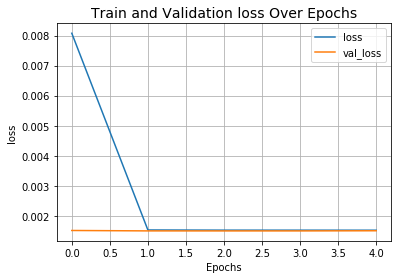

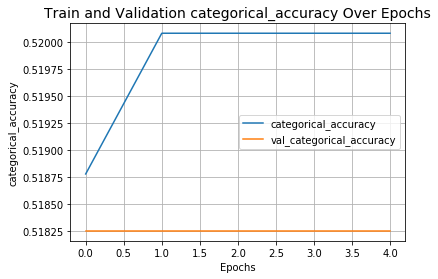

In [28]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Evaluate the model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predictions=model.predict([x_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]

for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

In [107]:
def predict_sample(text):
    encoded_text = tokenizer.texts_to_sequences(text)
    
    padded_docs = pad_sequences(encoded_text, maxlen=maxlen, padding='post')
    
    pred = model.predict(padded_docs).tolist()
    for i in range(len(pred[0])):
        if(pred[0][i] < 0.4):
            pred[0][i] = 0
        else:
            pred[0][i] = 1
    
    print("Predicted tags -->", vectorizer.inverse_transform(pred[0])[0])

In [27]:
import pickle

# saving
with open('models/tokenizer_last.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import dill

dill.dumps(vectorizer, open('models/vectorizer.pkl', 'wb'))

In [2]:
from tensorflow import keras
model = keras.models.load_model('models/model_last.h5')

In [4]:
import pickle

# loading
with open('models/tokenizer_last.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [94]:
encoded_text = tokenizer.texts_to_sequences(data["product_name"][350])
    
padded_docs = pad_sequences(encoded_text, maxlen=100, padding='post')

pred = model.predict(padded_docs).tolist()
for i in range(len(pred[0])):
    if(pred[0][i] < 0.4):
        pred[0][i] = 0
    else:
        pred[0][i] = 1

vectorizer.inverse_transform(pred[0])[0]

array(['unclassified'], dtype='<U244')

In [46]:
data["product_name"][5]

'The North Face S/S LFC Reaxion Crew Mens Turkish Sea/High Rise Grey L'